# WT vs LG3

In [1]:
library(sleuth)
library(splines)
library(scales)

Loading required package: ggplot2
Loading required package: dplyr

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
#https://stackoverflow.com/questions/41849951/using-ggplot-geo-geom-histogram-with-y-log-scale-with-zero-bins
mylog10_trans <- function (base = 10) 
{
  trans <- function(x) log(x + 1, base)
  inv <- function(x) base^x
  trans_new(paste0("log-", format(base)), trans, inv, log_breaks(base = base), 
            domain = c(1e-100, Inf))
}

In [3]:
d=read.delim("../kallisto/sample_descriptions/our_data.txt",sep="\t",stringsAsFactors=FALSE)
names(d)[1:2]=c("sample","sample_alias")
d$batch=as.numeric(gsub("^[^-]+-[^-]+-[^-]+-(\\d+$)$","\\1",gsub("([A-z]+)(\\d+)","\\1-\\2",d$sample,perl=TRUE),perl=TRUE))
d$batch[is.na(d$batch)]=1
table(d$batch)
d$harvest=sprintf("%id_b%i",d$Time,d$batch)
table(d$harvest)
head(d)

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


 1  2  3 
24 25 25 


12d_b1 12d_b2 12d_b3 14d_b1 14d_b2 14d_b3  3d_b1  3d_b2  3d_b3  5d_b1  5d_b2 
     5      5      5      5      5      5      4      5      5      5      5 
 5d_b3  9d_b1  9d_b2  9d_b3 
     5      5      5      5 

sample,sample_alias,Group,GT,Time,elongation_caulonema,protonemata_branching,number_buds_per_filament,percents_filaments_with_buds,gametophore_formation,colony_size,rhizoid_formation,development_of_phyllids,batch,harvest
1-W3,1.W3,1,WT,3,normal,normal,absent,absent,absent,normal,absent,absent,1,3d_b1
2-W3-2,2.W3.2,1,WT,3,normal,normal,absent,absent,absent,normal,absent,absent,2,3d_b2
3-W3-3,3.W3.3,1,WT,3,normal,normal,absent,absent,absent,normal,absent,absent,3,3d_b3
4-D3,4.D3,2,deltaDEK,3,normal,normal,absent,absent,absent,normal,absent,absent,1,3d_b1
5-D3-2,5.D3.2,2,deltaDEK,3,normal,normal,absent,absent,absent,normal,absent,absent,2,3d_b2
6-D3-3,6.D3.3,2,deltaDEK,3,normal,normal,absent,absent,absent,normal,absent,absent,3,3d_b3


In [4]:
#outlier replicates
exclude=d$sample[grep("5-3$",d$sample,perl=TRUE)]

In [5]:
d=subset(d,! sample %in% exclude )

In [6]:
table(d$GT,d$Time)

          
           3 5 9 12 14
  deltaDEK 3 2 3  3  3
  LG3      3 2 3  3  3
  Loop     3 2 3  3  3
  OE       2 2 3  3  3
  WT       3 2 3  3  3

In [7]:
table(file.exists(sprintf("../kallisto/kallisto/%s/abundance.h5",d$sample)))


TRUE 
  69 

In [8]:
d$path=sprintf("../kallisto/kallisto/%s/abundance.h5",d$sample)

In [9]:
m=read.delim("../analysis/cosmoss_V3.3.mRNA_ncRNA.tx2gene.full.tsv",stringsAsFactors=FALSE)
names(m)[1]="target_id"
m$class=ifelse(is.na(m$class),m$TYPE,m$class)
m$gene=paste(m$GENEID,m$class,sep=".")
m=m[,c("target_id","gene","class","TYPE")]
nrow(m)
head(m)

[1] 93962

target_id,gene,class,TYPE
Pp3c1_20V3.1,Pp3c1_20.mRNA,mRNA,mRNA
Pp3c1_20V3.2,Pp3c1_20.mRNA,mRNA,mRNA
Pp3c1_40V3.2,Pp3c1_40.mRNA,mRNA,mRNA
Pp3c1_40V3.1,Pp3c1_40.mRNA,mRNA,mRNA
Pp3c1_50V3.2,Pp3c1_50.mRNA,mRNA,mRNA
Pp3c1_50V3.1,Pp3c1_50.mRNA,mRNA,mRNA


In [10]:
D=droplevels(subset(d, GT %in% c("WT","LG3")))
head(D)
table(D$GT,D$Time)

,sample,sample_alias,Group,GT,Time,elongation_caulonema,protonemata_branching,number_buds_per_filament,percents_filaments_with_buds,gametophore_formation,colony_size,rhizoid_formation,development_of_phyllids,batch,harvest,path
1,1-W3,1.W3,1,WT,3,normal,normal,absent,absent,absent,normal,absent,absent,1,3d_b1,../kallisto/kallisto/1-W3/abundance.h5
2,2-W3-2,2.W3.2,1,WT,3,normal,normal,absent,absent,absent,normal,absent,absent,2,3d_b2,../kallisto/kallisto/2-W3-2/abundance.h5
3,3-W3-3,3.W3.3,1,WT,3,normal,normal,absent,absent,absent,normal,absent,absent,3,3d_b3,../kallisto/kallisto/3-W3-3/abundance.h5
10,10-LG3,10.LG3,4,LG3,3,reduced,normal,absent,absent,absent,reduced,absent,absent,1,3d_b1,../kallisto/kallisto/10-LG3/abundance.h5
11,11-LG3-2,11.LG3.2,4,LG3,3,reduced,normal,absent,absent,absent,reduced,absent,absent,2,3d_b2,../kallisto/kallisto/11-LG3-2/abundance.h5
12,12-LG3-3,12.LG3.3,4,LG3,3,reduced,normal,absent,absent,absent,reduced,absent,absent,3,3d_b3,../kallisto/kallisto/12-LG3-3/abundance.h5


     
      3 5 9 12 14
  LG3 3 2 3  3  3
  WT  3 2 3  3  3

In [11]:
so.D=sleuth_prep(D, target_mapping = m,aggregation_column = 'gene', extra_bootstrap_summary = TRUE)

reading in kallisto results
dropping unused factor levels
............................
normalizing est_counts
44922 targets passed the filter
normalizing tpm
merging in metadata
aggregating by column: gene
21679 genes passed the filter
Warning message in sleuth_prep(D, target_mapping = m, aggregation_column = "gene", :
“2 target_ids are missing annotations for the aggregation_column: gene.
These target_ids will be dropped from the gene-level analysis.
If you did not expect this, check your 'target_mapping' table for missing values.”summarizing bootstraps



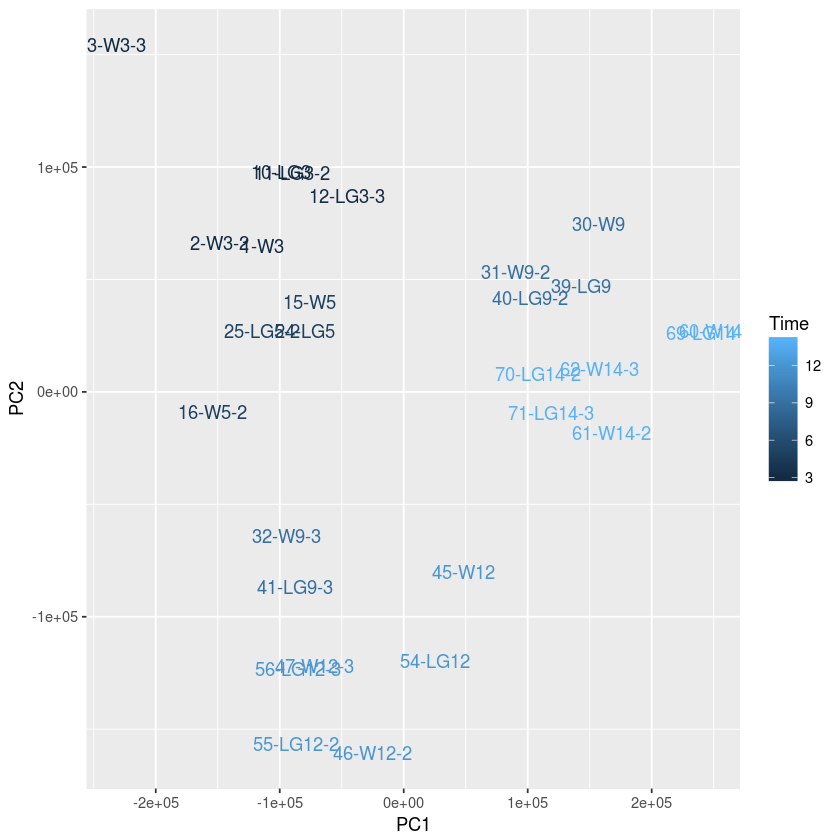

In [12]:
plot_pca(so.D, color_by = 'Time',text_labels = TRUE,units='scaled_reads_per_base')

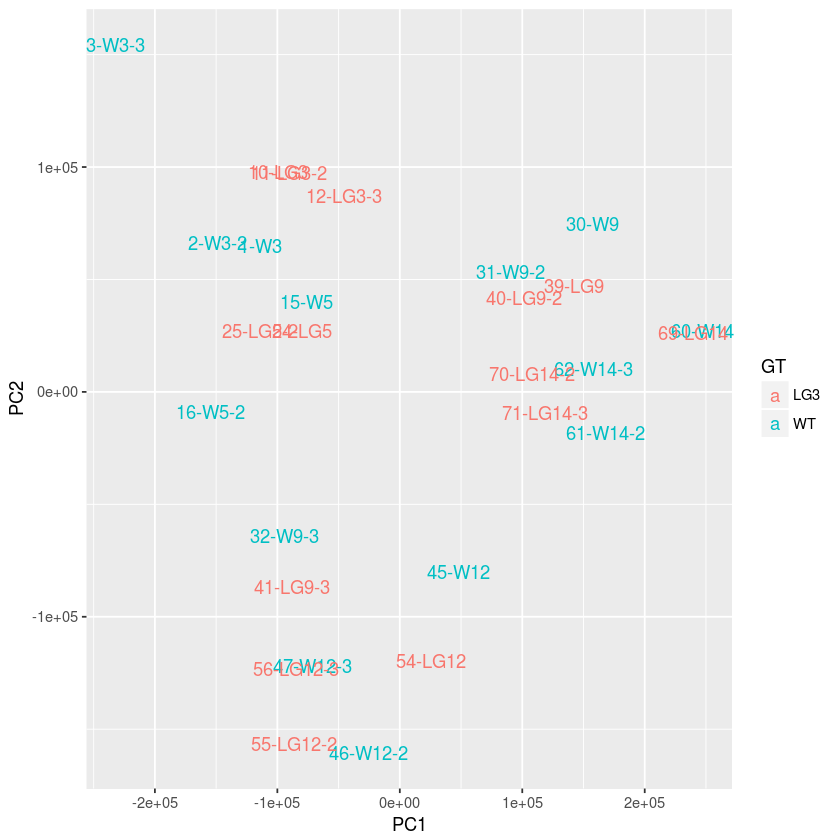

In [13]:
plot_pca(so.D, color_by = 'GT',text_labels = TRUE,units='scaled_reads_per_base')

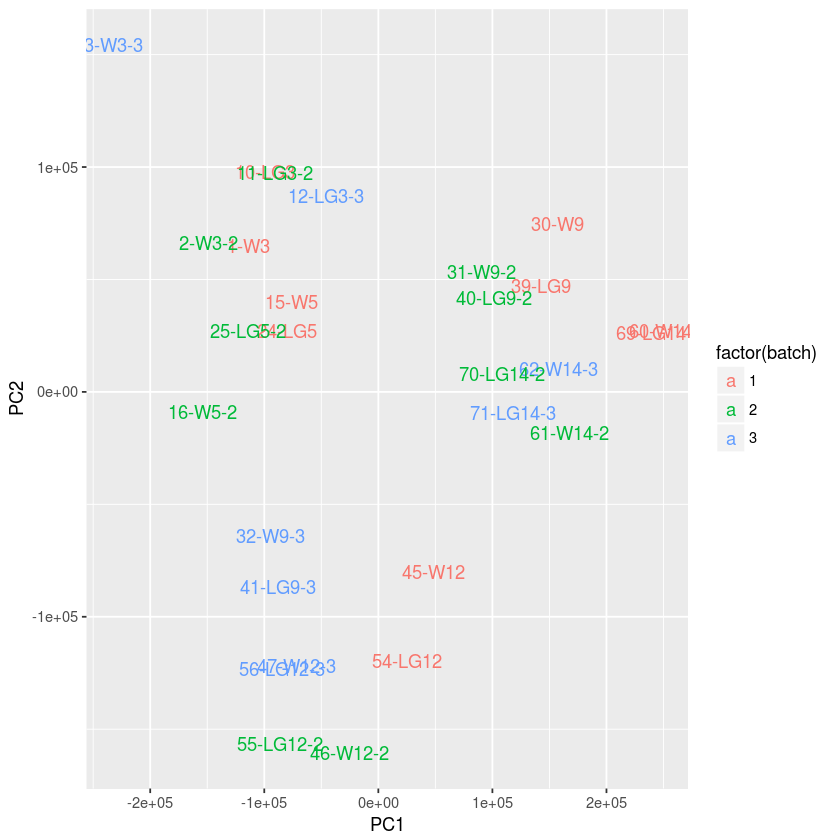

In [14]:
plot_pca(so.D, color_by = 'factor(batch)',text_labels = TRUE,units='scaled_reads_per_base',use_filtered=TRUE)

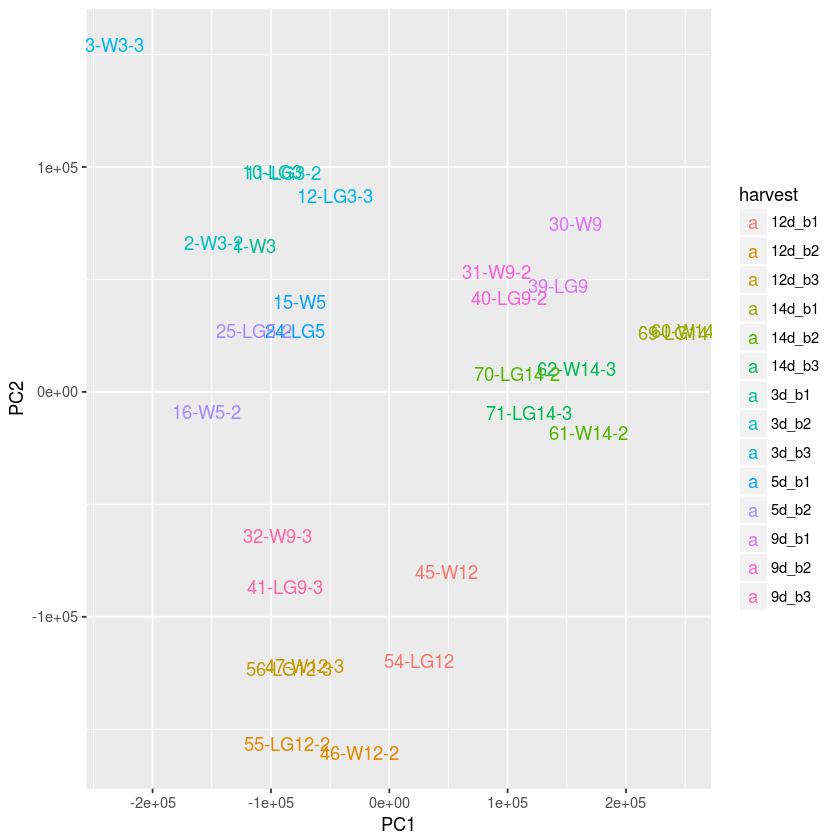

In [15]:
plot_pca(so.D, color_by = 'harvest',text_labels = TRUE,units='scaled_reads_per_base',use_filtered=TRUE)

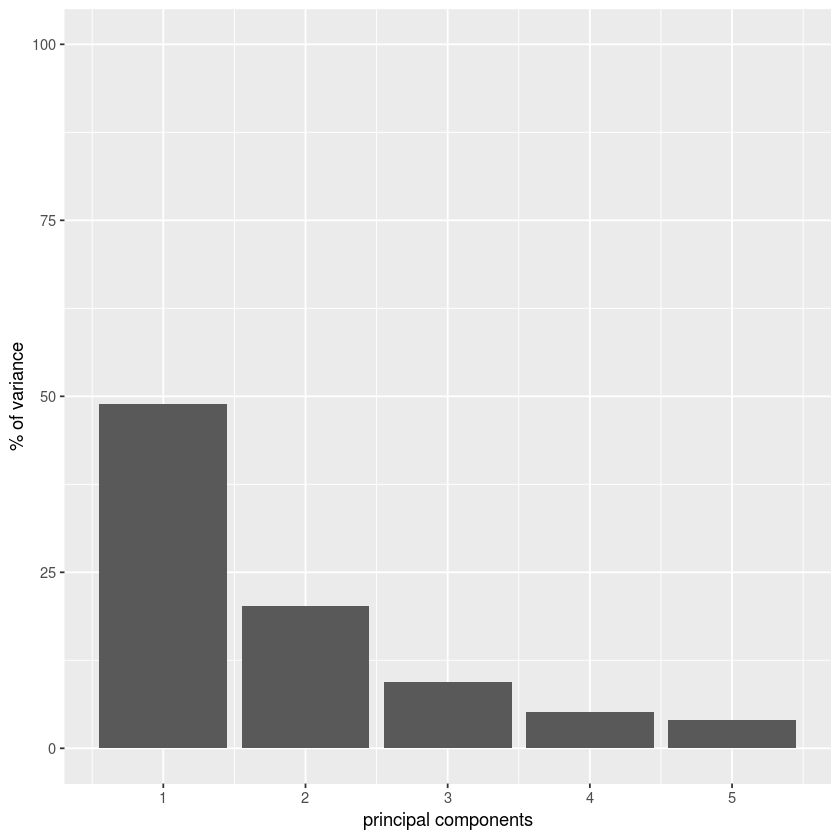

In [16]:
plot_pc_variance(so.D,units='scaled_reads_per_base')

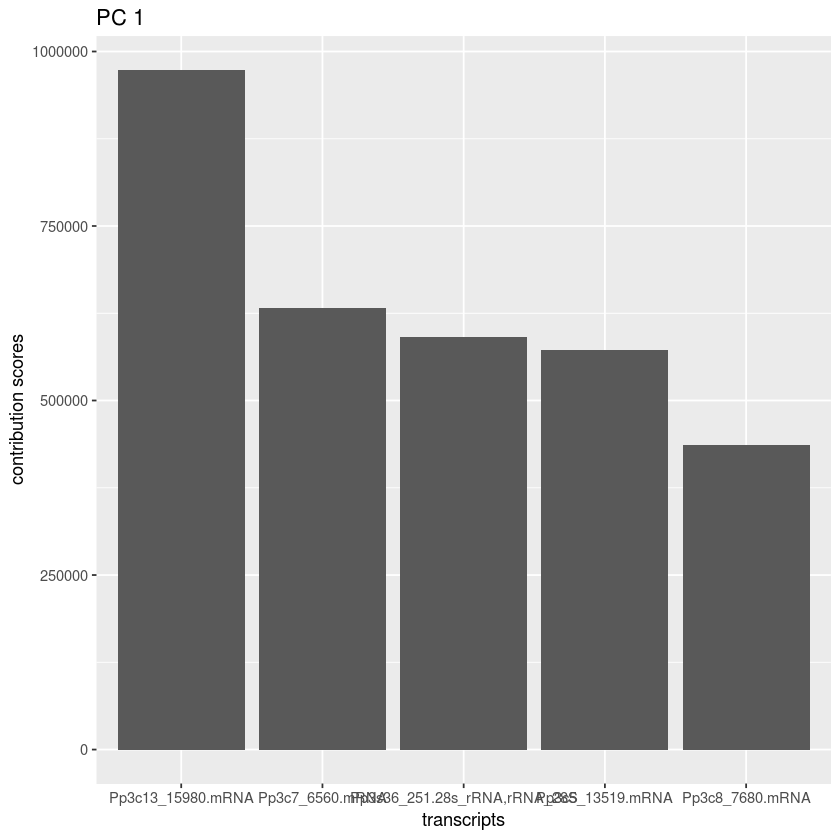

In [17]:
plot_loadings(so.D, pc_input = 1,units='scaled_reads_per_base')

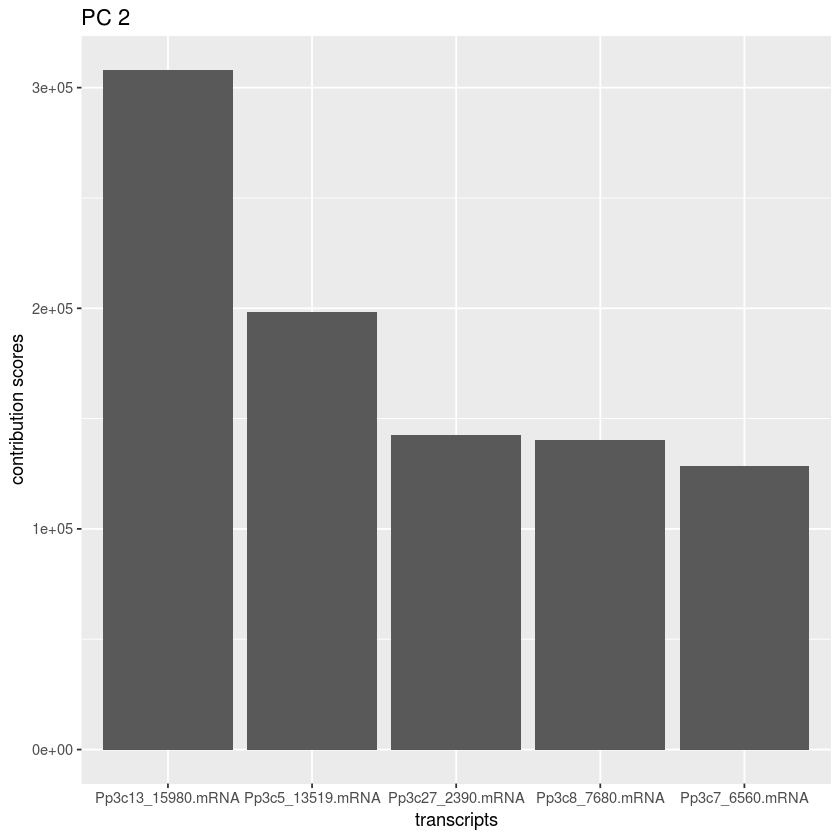

In [18]:
plot_loadings(so.D, pc_input = 2,units='scaled_reads_per_base')

Warning message:
“'switch' is deprecated.
Use 'strip.position' instead.
See help("Deprecated")”

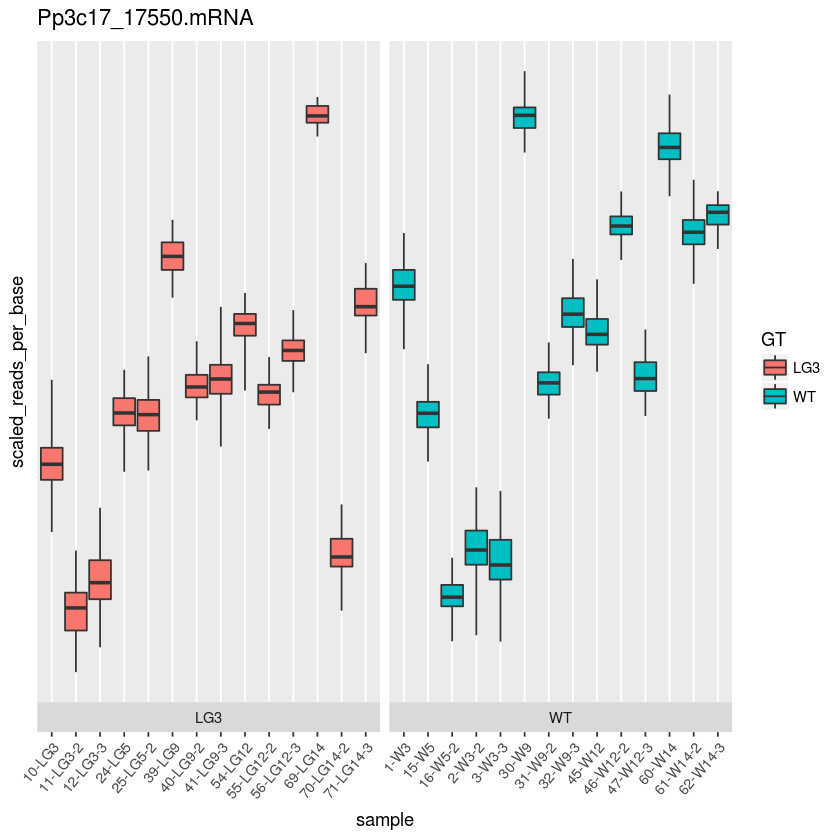

In [19]:
plot_bootstrap(so.D, 'Pp3c17_17550.mRNA', color_by = 'GT',units='scaled_reads_per_base') + scale_y_continuous(trans = "mylog10")

Warning message:
“'switch' is deprecated.
Use 'strip.position' instead.
See help("Deprecated")”

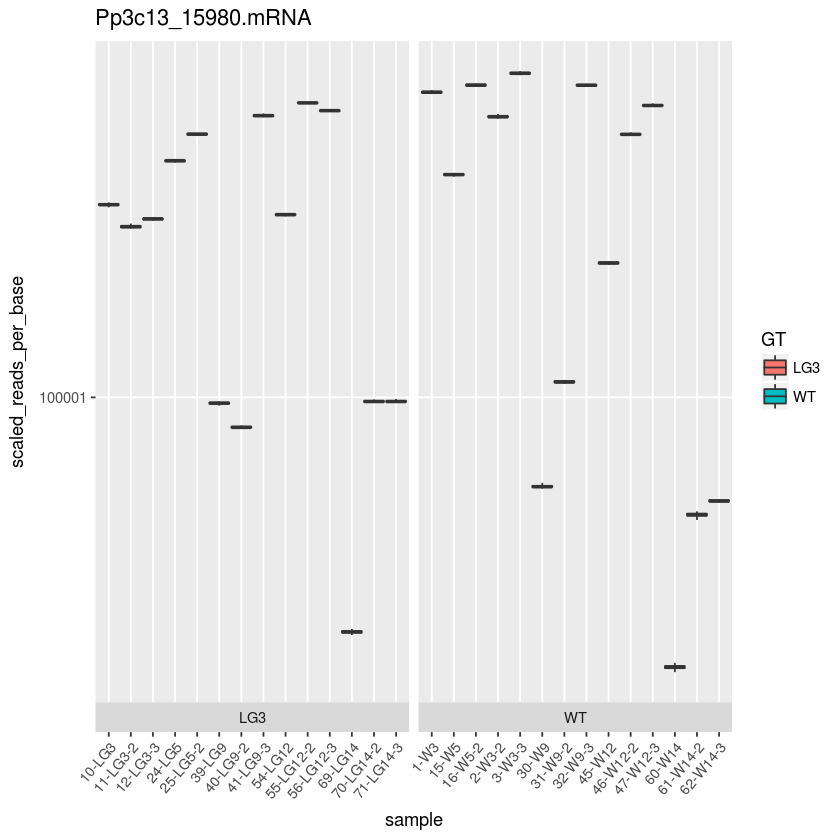

In [20]:
plot_bootstrap(so.D, 'Pp3c13_15980.mRNA', color_by = 'GT',units='scaled_reads_per_base') + scale_y_continuous(trans = "mylog10")

In [21]:
D$GT=relevel(factor(D$GT),"WT")

In [22]:
full_design <- model.matrix(formula(~ GT + ns(Time, df = 4)),data=D)
reduced_design <- model.matrix(formula(~ ns(Time, df = 4)),data=D)

In [23]:
full_design2 <- model.matrix(formula(~ GT + factor(batch) + ns(Time, df = 4)),data=D)
reduced_design2 <- model.matrix(formula(~ factor(batch) + ns(Time, df = 4)),data=D)

In [24]:
full_design2

,(Intercept),GTLG3,factor(batch)2,factor(batch)3,"ns(Time, df = 4)1","ns(Time, df = 4)2","ns(Time, df = 4)3","ns(Time, df = 4)4"
1,1,0,0,0,0.00000000,0.0000000,0.0000000,0.00000000
2,1,0,1,0,0.00000000,0.0000000,0.0000000,0.00000000
3,1,0,0,1,0.00000000,0.0000000,0.0000000,0.00000000
10,1,1,0,0,0.00000000,0.0000000,0.0000000,0.00000000
11,1,1,1,0,0.00000000,0.0000000,0.0000000,0.00000000
12,1,1,0,1,0.00000000,0.0000000,0.0000000,0.00000000
15,1,0,0,0,0.07407407,-0.1301890,0.4556617,-0.32547261
16,1,0,1,0,0.07407407,-0.1301890,0.4556617,-0.32547261
24,1,1,0,0,0.07407407,-0.1301890,0.4556617,-0.32547261
25,1,1,1,0,0.07407407,-0.1301890,0.4556617,-0.32547261


In [25]:
so.D= sleuth_fit(so.D,reduced_design2,fit_name="reduced2")

fitting measurement error models
shrinkage estimation
computing variance of betas


In [26]:
so.D= sleuth_fit(so.D, full_design2, fit_name = "full2")

fitting measurement error models
shrinkage estimation
computing variance of betas


In [27]:
so.D = sleuth_lrt(so.D, "reduced2", "full2")

In [28]:
models(so.D)

[  reduced2  ]
formula:  structure(c(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,  1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1,  0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,  0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,  1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0.0740740740740741, 0.0740740740740741,  0.0740740740740741, 0.0740740740740741, 0.603174603174603, 0.603174603174603,  0.603174603174603, 0.603174603174603, 0.603174603174603, 0.603174603174603,  0.0888888888888889, 0.0888888888888889, 0.0888888888888889, 0.0888888888888889,  0.0888888888888889, 0.0888888888888889, 0, 0, 0, 0, 0, 0, 0,  0, 0, 0, 0, 0, -0.130189045660703, -0.130189045660703, -0.130189045660703,  -0.130189045660703, 0.209559381722464, 0.209559381722464, 0.209559381722464,  0.209559381722464, 0.209559381722464, 0.209559381722464, 0.587464387464387,  0.587464387464387, 0.587464387464387, 0.587464387464387, 0.587464387464387,  0.587464387464387, -0.128205128205128, -0

In [29]:
so.D = sleuth_wt(so.D, 'GTLG3', which_model = "full2")

Warning message:
“Removed 6 rows containing missing values (geom_point).”

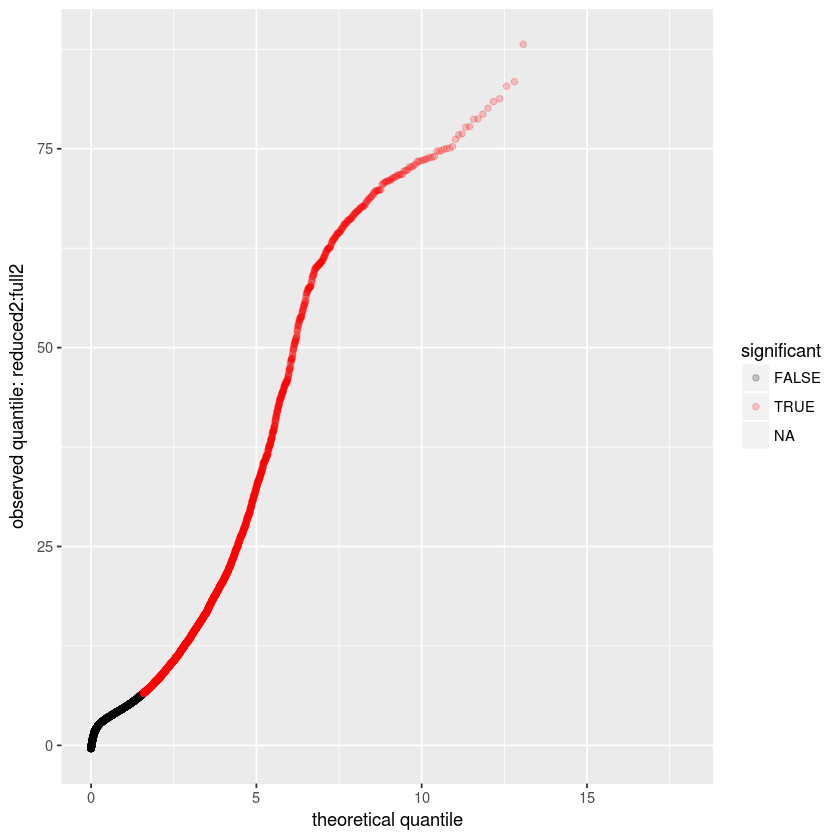

In [30]:
plot_qq(so.D, test = 'reduced2:full2', test_type = 'lrt', sig_level = 0.05)

Warning message:
“Removed 6 rows containing missing values (geom_path).”

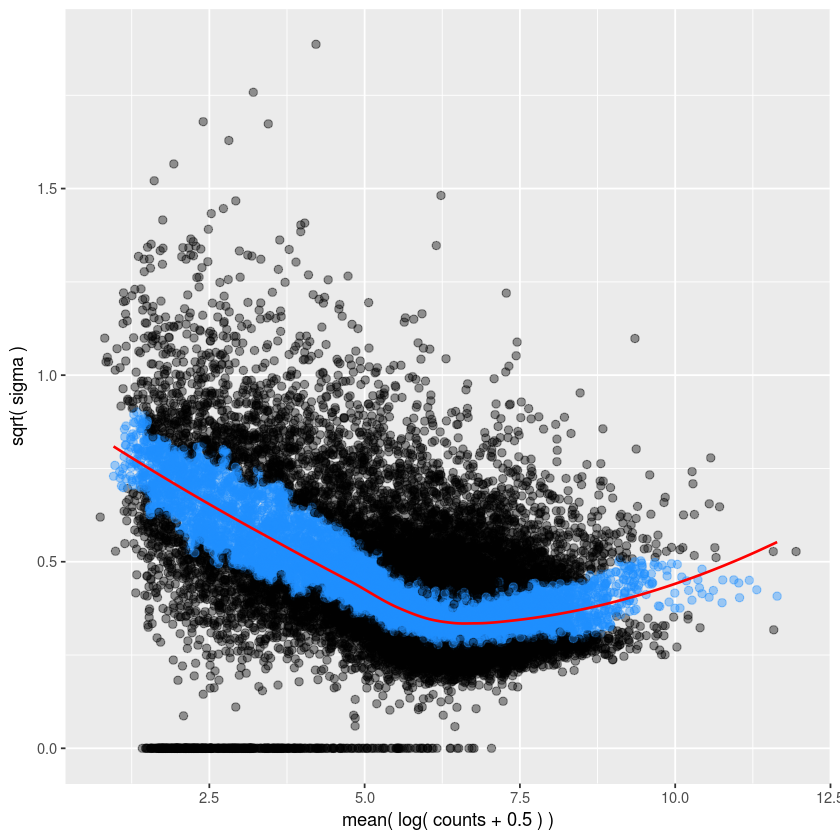

In [31]:
plot_mean_var(so.D,which_model="full2")

In [32]:
tt=sleuth_results(so.D,'GTLG3','wt',which_model="full2" ,show_all = FALSE,rename_cols=FALSE)
tt.sig= dplyr::filter(tt, qval < 0.05)
nrow(tt.sig)
table(tt.sig$b>0)

[1] 3294


FALSE  TRUE 
 1528  1766 

In [33]:
lrt_results= sleuth_results(so.D, 'reduced2:full2', test_type = 'lrt',show_all=TRUE)

In [34]:
o=na.omit(merge(lrt_results,tt,by="target_id",suffixes=c(".lrt",".wt")))
o=o[order(-o$b,-o$test_stat),]
table(o$b>0)
head(o[o$b>0,])


FALSE  TRUE 
11551 10122 

,target_id,test_stat,pval.lrt,qval.lrt,rss,sigma_sq.lrt,tech_var,mean_obs.lrt,var_obs.lrt,sigma_sq_pmax,⋯,pval.wt,qval.wt,b,se_b,mean_obs.wt,var_obs.wt,sigma_q_sq,sigma_sq.wt,smooth_sigma_sq.wt,smooth_sigma_sq_pmax
12359,Pp3c22_9051.mRNA,9.532817,2.018301e-03,1.536986e-02,207.35491,6.810651,3.0633923,2.531395,9.146417,6.810651,⋯,3.587135e-03,2.817832e-02,2.970084,1.0198218,2.531395,9.146417,3.0633923,4.2168631,0.17976802,4.2168631
5097,Pp3c14_2570.mRNA,20.094409,7.371184e-06,1.543533e-04,110.09033,2.487592,2.7548052,2.819490,5.493955,2.487592,⋯,6.097959e-06,1.252761e-04,2.914361,0.6443476,2.819490,5.493955,2.7548052,-0.2230132,0.15148120,0.1514812
4179,Pp3c13_21810.mRNA,45.748246,1.344697e-11,9.164660e-10,60.57702,2.624109,0.2605111,2.379579,3.249648,2.624109,⋯,5.414982e-20,3.798023e-18,2.643255,0.2887095,2.379579,3.249648,0.2605111,0.3229610,0.19640945,0.3229610
3500,Pp3c12_24740.mRNA,33.295702,7.915740e-09,3.267768e-07,53.66426,2.417354,0.1380870,1.506107,2.948815,2.417354,⋯,8.935026e-12,3.849877e-10,2.315678,0.3394082,1.506107,2.948815,0.1380870,0.6682987,0.32024142,0.6682987
2267,Pp3c11_12000.mRNA,32.698801,1.076036e-08,4.326702e-07,50.83169,2.307363,0.1131940,2.407141,2.808813,2.307363,⋯,1.829301e-11,7.632891e-10,2.243279,0.3338691,2.407141,2.808813,0.1131940,0.6670860,0.19329392,0.6670860
21427,"Pp3s248_20.28s_rRNA,rRNA_28S",2.872485,9.010565e-02,1.550258e-01,298.93090,13.589164,0.6456411,4.216614,12.326721,13.589164,⋯,1.173464e-01,3.327319e-01,2.159731,1.3791298,4.216614,12.326721,0.6456411,12.6683515,0.06056284,12.6683515


In [35]:
m1=read.delim("../analysis//cosmoss_V3.3.mRNA_ncRNA.tx2gene.full.gene_wise.tsv",sep="\t",stringsAsFactors=FALSE)
names(m1)[1]="target_id"
head(m1)

target_id,spectype,TXNAME,GENEID,TYPE,Alias,support,origin,isoform,longest_transcript,has_evidence,class,has_protein_homology,has_proteomics_support,encoded_by,is_filtered
Pp3c10_10000.tRNA,tRNA,Pp3c10_10000V3.1,Pp3c10_10000,ncRNA,"tRNA,Pp3c10_10000N1.1,Pp3c10_10000V1.1,N1.Chr10.ncRNA.54,tRNA.717",supported_by_sequence_similarity,RFAM11.Infernal1.1,major,true,false,tRNA,false,false,ncRNA_gene,false
Pp3c10_10040.mRNA,mRNA,"Pp3c10_10040V3.2,Pp3c10_10040V3.3,Pp3c10_10040V3.5,Pp3c10_10040V3.6,Pp3c10_10040V3.4,Pp3c10_10040V3.1",Pp3c10_10040,mRNA,"PAC4GC:5701563,Pp3c10_10040J4.1,Pp1s58_283V6.2,PAC4GC:5701564,P2.evm.model.Chr10.357,Pp3c10_10040J5.3,Pp3c10_10040J5.4,Pp3c10_10040V1.1,P2.Chr10.mRNA.3452,Phpatv32029367m,PAC4GC:5701565,Phpatv32029366m,PAC4GC:5701561,Pp3c10_10040J5.2,Pp1s58_283V6.1,Pp3c10_10040J5.1,Phpatv32029364m,Pp3c10_10040P2.1,Phpatv32029365m,Phpatv32029363m,P2.EVM%20prediction%20Chr10.357,Pp3c10_10040P2.2,PAC4GC:5701562",supported_by_EST_or_cDNA,NA,"alternative,major","true,false",true,NA,true,false,protein_coding_gene,false
Pp3c10_10090.mRNA,mRNA,"Pp3c10_10090V3.2,Pp3c10_10090V3.1",Pp3c10_10090,mRNA,"Phpatv32029368m,Pp3c10_10090V1.1,J3.Chr10.mRNA.912,J3.Phypav3.0.4_pg25522.valid.m1,J3.7022241,Pp3c10_10090J4.1,Pp3c10_10090J3.1,PAC4GC:5700224,pred.234120000946",supported_by_EST_or_cDNA,NA,"major,alternative","false,true",true,NA,false,false,protein_coding_gene,false
Pp3c10_10095.C_D_box_snoRNA,C_D_box_snoRNA,Pp3c10_10095V3.1,Pp3c10_10095,ncRNA,"Chr10.snoRNA.21,snoR64.1,Chr10.snoRNA.22,Pp3c10_10095V1.1,Chr10.snoRNA.32,Chr10.snoRNA.23,snoR64,N1.Chr10.ncRNA.55,Pp3c10_10095N1.1,Chr10.snoRNA.33,snR72%2FZ2,snR58",supported_by_sequence_similarity,"RFAM11.Infernal1.1,snoscan-0.9b",major,true,true,C_D_box_snoRNA,false,false,ncRNA_gene,false
Pp3c10_100.ncRNA,ncRNA,Pp3c10_100V3.1,Pp3c10_100,ncRNA,"Pp3c10_100V1.1,Pp3c10_100P0.1,asmbl_110854",supported_by_EST_or_cDNA,NA,major,true,true,NA,false,false,ncRNA_gene,false
Pp3c10_10100.mRNA,mRNA,"Pp3c10_10100V3.1,Pp3c10_10100V3.4,Pp3c10_10100V3.2,Pp3c10_10100V3.5,Pp3c10_10100V3.3",Pp3c10_10100,mRNA,"Pp3c10_10100J5.3,Phpatv32029369m,PAC4GC:5701591,PAC4GC:5701593,Pp1s58_289V6.1_29440,PAC4GC:5701592,Phpatv32029370m,Pp3c10_10100V1.1,Phpatv32029372m,Pp3c10_10100J5.1,Pp3c10_10100J5.2,C1.Pp1s58_289V6.1,Phpatv32029371m,C1.560145,PAC4GC:5701590,Pp1s58_289V6.1,C1.Chr10.mRNA.576,Pp3c10_10100J4.1,Pp3c10_10100C1.1",supported_by_EST_or_cDNA,NA,"alternative,major","true,false",true,NA,true,false,protein_coding_gene,false


In [36]:
m2=read.delim("../analysis//cosmoss.genonaut.V3.3.gene_and_protein_names.tsv",sep="\t",col.names=c("GENEID","name"),stringsAsFactors=FALSE)
head(m2)

GENEID,name
Pp3c10_13310,XTH28
Pp3c10_13800,"CHR1545,chr1545"
Pp3c10_13960,"CHLH1,chlh2,CHLH2,chlh1"
Pp3c10_13970,"chlh1,CHLH2,chlh2,CHLH1"
Pp3c10_14020,"raba53,RABA53"
Pp3c10_14800,"ppr_20,PPR_20"


In [37]:
m3=read.delim("../analysis//Ppatens_318_v3.3.defline.txt",sep="\t",col.names=c("GENEID","source","defline"),stringsAsFactors=FALSE)
m3$GENEID=gsub("V3\\.\\d+","",m3$GENEID,perl=TRUE)
head(m3)

GENEID,source,defline
Pp3c10_10220,pdef,"K00615 - transketolase (E2.2.1.1, tktA, tktB) (1 of 4)"
Pp3c10_10230,pdef,K14763 - H/ACA ribonucleoprotein complex non-core subunit NAF1 (NAF1) (1 of 1)
Pp3c10_10240,pdef,PTHR10641:SF599 - MYB TRANSCRIPTION FACTOR-RELATED (1 of 3)
Pp3c10_10270,pdef,2.4.1.12 - Cellulose synthase (UDP-forming) / UDP-glucose-cellulose glucosyltransferase (1 of 17)
Pp3c10_10460,pdef,"K03320 - ammonium transporter, Amt family (amt, AMT, MEP) (1 of 12)"
Pp3c10_10490,pdef,"PTHR11177:SF167 - RHODANESE-LIKE DOMAIN-CONTAINING PROTEIN 4, CHLOROPLASTIC (1 of 3)"


In [38]:
m4=read.delim("../analysis//Physcomitrella_patens.TAP_annotation.6.tsv",sep="\t")
names(m4)[2]="GENEID"
head(m4)

superfamily,GENEID,inferred_by_rule,TAP_class
BSD domain containing,Pp3c11_12590V3,True,PT
BSD domain containing,Pp3c1_21290V3,True,PT
BSD domain containing,Pp3c20_12230V3,True,PT
BSD domain containing,Pp3c23_10600V3,True,PT
BSD domain containing,Pp3c24_7080V3,True,PT
BSD domain containing,Pp3c26_14480V3,True,PT


In [39]:
O=merge(o,m1,by="target_id")
nrow(o)
nrow(O)
O=merge(O,m2,by="GENEID",all.x=TRUE)
nrow(O)
O=merge(O,m3,by="GENEID",all.x=TRUE)
nrow(O)
O=merge(O,m4,by="GENEID",all.x=TRUE)
nrow(O)
O=O[order(-O$test_stat),]
head(O)

[1] 21673

[1] 21673

[1] 21673

[1] 21673

[1] 21673

,GENEID,target_id,test_stat,pval.lrt,qval.lrt,rss,sigma_sq.lrt,tech_var,mean_obs.lrt,var_obs.lrt,⋯,has_protein_homology,has_proteomics_support,encoded_by,is_filtered,name,source,defline,superfamily,inferred_by_rule,TAP_class
13182,Pp3c24_13920,Pp3c24_13920.mRNA,88.12742,6.137110e-21,1.330096e-16,6.333253,0.2995352,0.0020482457,6.910315,0.2447673,⋯,true,true,protein_coding_gene,false,NA,pdef,"PTHR12056 - DNA-DIRECTED RNA POLYMERASES I, II, AND III (1 of 1)",NA,NA,NA
13370,Pp3c24_19500,Pp3c24_19500.mRNA,83.43410,6.587565e-20,6.376288e-16,3.350023,0.1587611,0.0007637707,7.310712,0.1335318,⋯,true,true,protein_coding_gene,false,NA,pdef,1.1.1.41 - Isocitrate dehydrogenase (NAD(+)) / Nicotinamide adenine dinucleotide isocitrate dehydrogenase (1 of 6),NA,NA,NA
13221,Pp3c24_15180,Pp3c24_15180.mRNA,82.85584,8.826126e-20,6.376288e-16,4.158485,0.1974070,0.0006160653,7.492890,0.1628644,⋯,true,true,protein_coding_gene,false,NA,NA,NA,NA,NA,NA
13570,Pp3c24_6340,Pp3c24_6340.mRNA,81.29588,1.943312e-19,1.009560e-15,3.489269,0.1650930,0.0010626393,6.966696,0.1373818,⋯,true,true,protein_coding_gene,false,NA,pdef,PTHR31521:SF2 - EXPRESSED PROTEIN (1 of 4),NA,NA,NA
13527,Pp3c24_5170,Pp3c24_5170.mRNA,80.93804,2.329073e-19,1.009560e-15,3.994918,0.1885276,0.0017066284,6.562653,0.1619666,⋯,true,"true,false",protein_coding_gene,false,NA,pdef,K17426 - large subunit ribosomal protein L45 (MRPL45) (1 of 1),NA,NA,NA
13564,Pp3c24_6150,Pp3c24_6150.mRNA,80.09611,3.566342e-19,1.288222e-15,3.717169,0.1759934,0.0010146266,7.021207,0.1708393,⋯,true,true,protein_coding_gene,false,NA,NA,NA,NA,NA,NA


In [40]:
t(O[ O$target_id=='Pp3c17_17550.mRNA',])

,7347
GENEID,Pp3c17_17550
target_id,Pp3c17_17550.mRNA
test_stat,4.562572
pval.lrt,0.03267797
qval.lrt,0.09759263
rss,0.2741265
sigma_sq.lrt,0.01238336
tech_var,0.0006702829
mean_obs.lrt,7.385312
var_obs.lrt,0.03203569


In [41]:
table(o$qval.lrt<0.05)
table(o$qval.wt<0.05)
table(o$qval.lrt<0.05,o$qval.wt<0.05)


FALSE  TRUE 
17186  4487 


FALSE  TRUE 
18379  3294 

       
        FALSE  TRUE
  FALSE 17186     0
  TRUE   1193  3294

In [42]:
head(O[,c("target_id","test_stat","b","qval.lrt","qval.wt","name","superfamily","TAP_class","defline")],n=50)

,target_id,test_stat,b,qval.lrt,qval.wt,name,superfamily,TAP_class,defline
13182,Pp3c24_13920.mRNA,88.12742,0.9317087,1.330096e-16,1.602404e-87,NA,NA,NA,"PTHR12056 - DNA-DIRECTED RNA POLYMERASES I, II, AND III (1 of 1)"
13370,Pp3c24_19500.mRNA,83.43410,0.6841977,6.376288e-16,1.022209e-48,NA,NA,NA,1.1.1.41 - Isocitrate dehydrogenase (NAD(+)) / Nicotinamide adenine dinucleotide isocitrate dehydrogenase (1 of 6)
13221,Pp3c24_15180.mRNA,82.85584,0.7556748,6.376288e-16,2.246742e-57,NA,NA,NA,NA
13570,Pp3c24_6340.mRNA,81.29588,0.6927946,1.009560e-15,1.169978e-51,NA,NA,NA,PTHR31521:SF2 - EXPRESSED PROTEIN (1 of 4)
13527,Pp3c24_5170.mRNA,80.93804,0.7382393,1.009560e-15,1.502613e-56,NA,NA,NA,K17426 - large subunit ribosomal protein L45 (MRPL45) (1 of 1)
13564,Pp3c24_6150.mRNA,80.09611,0.7118713,1.288222e-15,3.215284e-54,NA,NA,NA,NA
13508,Pp3c24_4700.mRNA,79.33897,0.6839777,1.619826e-15,9.972729e-50,NA,NA,NA,"4.2.1.107 - 3-alpha,7-alpha,12-alpha-trihydroxy-5-beta-cholest-24-enoyl-CoA hydratase / D-3-hydroxyacyl-CoA dehydratase (1 of 1)"
13551,Pp3c24_5950.mRNA,78.77276,0.6974132,1.745610e-15,2.105643e-52,NA,NA,NA,K15423 - serine/threonine-protein phosphatase 4 catalytic subunit (PPP4C) (1 of 2)
13419,Pp3c24_20680.mRNA,78.69473,0.6713048,1.745610e-15,1.523805e-47,NA,NA,NA,K02730 - 20S proteasome subunit alpha 1 (PSMA6) (1 of 3)
13685,Pp3c24_9600.mRNA,77.78738,0.6619931,2.346492e-15,1.397137e-45,NA,NA,NA,PTHR23417:SF16 - TRNA (GUANINE-N(7)-)-METHYLTRANSFERASE (1 of 1)


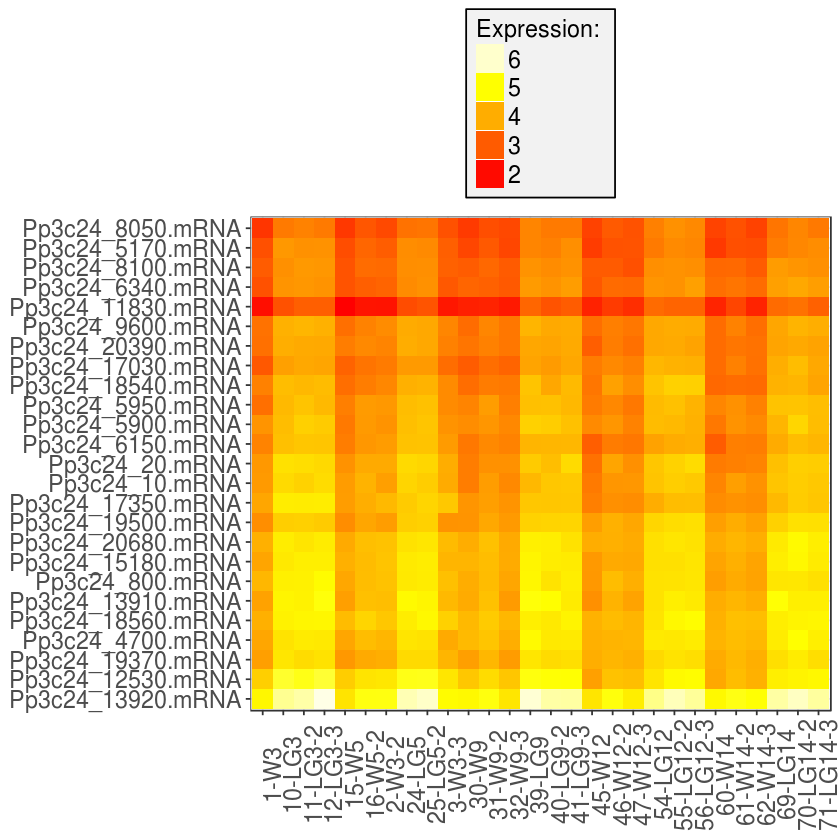

In [43]:
plot_transcript_heatmap(so.D, head(O, n = 25)$target_id)

In [44]:
subset(O,spectype=="pre_miRNA" & qval.lrt<0.1)[,c("target_id","test_stat","b","qval.lrt","qval.wt","Alias")]

,target_id,test_stat,b,qval.lrt,qval.wt,Alias
13621,Pp3c24_7848.pre_miRNA,24.699091,0.5807710,1.871692e-05,2.136925e-06,"Pp3c24_7848V1.1,N1.Chr24.ncRNA.42,Pp3c24_7848N1.1,MI0005932,ppt-MIR536d"
7058,Pp3c16_9758.pre_miRNA,11.292754,0.3971544,7.393159e-03,1.264459e-02,"MI0003501,Pp3c16_9758N1.1,ppt-MIR534a,N1.Chr16.ncRNA.50,Pp3c16_9758V1.1"
8426,Pp3c18_7951.pre_miRNA,9.037045,0.2276737,1.891425e-02,3.494749e-02,"Pp3c18_7951V1.1,Pp3c18_7951N1.1,ppt-MIR319a,N1.Chr18.ncRNA.41,MI0003496"
16837,Pp3c4_3072.pre_miRNA,7.487179,-0.9325504,3.542232e-02,6.585684e-02,"N1.Chr04.ncRNA.14,ppt-MIR1042,MI0006001,Pp3c4_3072V1.1,ppt-MIR1043,Pp3c4_3072V1.2,MI0006002,Pp3c4_3072N1.1,N1.Chr04.ncRNA.15,Pp3c4_3072N1.2"
12850,Pp3c23_3768.pre_miRNA,6.768574,0.2496502,4.651833e-02,8.685830e-02,"Pp3c23_3768V1.1,ppt-MIR536b,MI0005691,Pp3c23_3768N1.1,N1.Chr23.ncRNA.15"
4411,Pp3c13_7201.pre_miRNA,5.405257,-0.1679210,7.557953e-02,2.310775e-01,"MI0005966,Pp3c13_7201V1.1,ppt-MIR1025,Pp3c13_7201N1.1,N1.Chr13.ncRNA.30"
12152,Pp3c22_2794.pre_miRNA,4.916576,0.2550652,8.796242e-02,1.697167e-01,"MI0003499,Pp3c22_2794N1.1,MIR159.3,ppt-MIR319d,Pp3c22_2794V1.1,N1.Chr22.ncRNA.13,MIR159"


In [45]:
write.table(o,gzfile("comp.WT_vs_LG3/dge.tsv.gz"),sep="\t",col.names=TRUE,row.names=FALSE,quote=FALSE)
write.table(O,gzfile("comp.WT_vs_LG3/dge.full.tsv.gz"),sep="\t",col.names=TRUE,row.names=FALSE,quote=FALSE)